# Pump It Up Data Mining the Water Table

## Content:
1. [Introduction](#first-bullet)
2. [Data Overview](#second-bullet)
    * [Loading Datasets](#second1-bullet)
    * [Changing Data Type](#second2-bullet)
    * [Data Profile](#second3-bullet)
* [Data Cleaning](#third-bullet)
    * [Handeling Outliers](#third1-bullet)
    * [Handeling Missing Values](#third2-bullet)
        * [Binning](#third21-bullet)
        * [Kmode Clustering](#third22-bullet)
        * [Missing Value Imputation](#third23-bullet)
* [Data Exploration](#forth-bullet)
    * [More Data Cleaning](#forth1-bullet)
* [Dataset Balance](#fifth-bullet)
* [Train and Validation Split](#six-bullet)
* [Feature Engineering]
    * [PCA]
* [Modeling- Random Forest]
    * [LDA]
    * [Baseline Model]
* [Modeling- SVM]
* `[The Pipeline](#fifth-bullet)


In [1]:
# pip install pandas-profiling[notebook,html]
# pip install kmodes
# pip install --upgrade kmodes

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from kmodes.kmodes import KModes
from sklearn.model_selection import KFold
from sklearn.utils import resample ##
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm


from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: column;
}
"""

HTML('<style>{}</style>'.format(CSS))

## 1. Introduction <a class="anchor" id="first-bullet"></a>

This project, using data from Taarifa and the Tanzanian Ministry of Water, predicts which water pumps are functional, which need some repairs, and which don't work at all. As such, this is a multi-class classification problem.

The aim is to provide insight as to which waterpoint might fail and which variables are able to strongly predict this to improve maintainace and ensure clean and portable water is available to communities in Tanzania.

## 2. Data Overview 

   ### 2.1. Loading Datasets <a class="anchor" id="second1-bullet"></a>

In [3]:
training_label = pd.read_csv("data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
training_values = pd.read_csv("data/4910797b-ee55-40a7-8668-10efd5c1b960.csv")
test = pd.read_csv("data/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")

train = training_values.merge(training_label, on = 'id')


test['status_group'] = '*unknown*'#the unknown target variable

#We will annotate our train and test set before combining them for simple indexing later on. 
train['data_set'] = 'train'
test['data_set'] = 'test'

trainset = pd.DataFrame(train)
testset = pd.DataFrame(test)

display(Markdown("There are {} observations in training set, and {} observations in the test set:{} observations in total.".format(len(train), len(test), len(train) + len(test))))
display(Markdown("There are {} variables in training dataset including the target variable.".format(len(train.columns))))

There are 59400 observations in training set, and 14850 observations in the test set:74250 observations in total.

There are 42 variables in training dataset including the target variable.

In [4]:
dataset = trainset.append(testset)
dataset.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,data_set
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train


In [5]:
dataset[:59400].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

### 2.2. Data Type <a class="anchor" id="second2-bullet"></a>

The data loaded recognized numeric and object variable in our dataset. We need to change these to categories and also change other variables which are defined as numbers into categories. 

In [6]:
#Changing datatypes from Objects to Categories.
for col in dataset:
    if dataset.dtypes[col].name == 'object':
        dataset[col] = dataset[col].astype('category')

In [7]:
#Setting other varaibles defined as numbers to categories. 
other_categoricals = ['id', 'district_code', 'construction_year', 'region_code'] #removed gps_height
dataset[other_categoricals] = dataset[other_categoricals].astype('category')

### 2.3. Data Profile <a class="anchor" id="second3-bullet"></a>

The profile of training set in our dataset highlights key aspects of our data, including correlations, missing values, and distribution. We will further explore the variables one by one below. 

In [8]:
# profile = ProfileReport(trainset,title='Training Dataset Summary Report', html={'style':{'full_width':True}})

In [9]:
# profile.to_notebook_iframe()

#### Status Group <a class="anchor" id="imbalance-bullet"></a>

In [10]:
status_group=pd.DataFrame(trainset["status_group"].value_counts())
status_group['%']=(trainset["status_group"].value_counts())/len(trainset)*100
status_group

,status_group,%
functional,32259,54.308081
non functional,22824,38.424242
functional needs repair,4317,7.267677


<div class="alert alert-block alert-success">
The classes in our train set is unbalanced as we have very small proportion for 'Functional Needs Repair'. We will test both upsample and undersample method later on and find the optimal method to balance the classes. 

## 3. Data Cleaning <a class="anchor" id="third-bullet"></a>

### 3.1. Tracking Null Values, Duplicates, Errors and Redundancy

In [11]:
dataset.isna().sum()[dataset.isna().sum().ne(0)]

funder                4504
installer             4532
subvillage             470
public_meeting        4155
scheme_management     4846
scheme_name          35258
permit                3793
dtype: int64

We have 7 variables ('funder', 'installer', 'subvillage','public_meeting', 'public_meeting', 'scheme_management', 'scheme_name', 'permit') with missing values. 
However, the dataset [profile shows](#second3-bullet) there are variables below that have zeros:
    - "amount_sth"
    - "population"
    - "gps_height"
    - "construction_year"
We will further investigate below each features and those highly correlated to see if there are amendments to be made.

Text(0.5, 0.98, '')

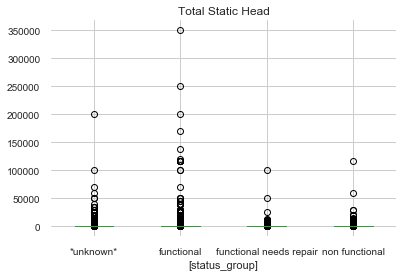

In [12]:
axes = dataset.boxplot(column=['amount_tsh'],by=['status_group']).set_title('Total Static Head')
fig = axes.get_figure()
fig.suptitle('')

<div class="alert alert-block alert-success">
There are alot of '0' values for amount of static head for working pumps which is an error. We will change this values to NaN and impute them as missing values. This is becuase it is not possible to have **'functional'** and **'functional needs repair'** pumps with zero value for static head.

The above variables were identified because they were numeric, however we will need to manually check if there are '0's as string under categories and idenfify if they are errors, missing values or valid inputs.

In [13]:
dataset.isin(['0']).sum(axis=0)[dataset.isin(['0']).sum(axis=0).ne(0)]

funder       980
installer    980
dtype: int64

In [14]:
dataset.isin([0]).sum(axis=0)[dataset.isin([0]).sum(axis=0).ne(0)]

id                       1
amount_tsh           52049
gps_height           25649
longitude             2269
num_private          73299
district_code           27
population           26834
public_meeting        6346
permit               21851
construction_year    25969
dtype: int64

<div class="alert alert-block alert-success">
It is possible for district code to be 0, and **public_meeting** and **permit** are a boolean column thus having a zero value means false.

##### <font color=#0078CC>Longitude and Latitude</font>

<div class="alert alert-block alert-success">
Tanzania is located between latitudes 1°S and 12°S and longitudes 29°E to 41°E. Thus a zero degree in longitude is an error or in this case considered a missing value. Moreover, there are locations that have specifically latitudes outside this range for Tanzania. These values will also be considered as missing values and imputed.

In [15]:
#The Values here are the zeros identified above
len(pd.DataFrame(dataset[(dataset['longitude']< 29) | (dataset['longitude']>41)]))

2269

In [16]:
len(pd.DataFrame(dataset[(dataset['latitude']> -1) | (dataset['latitude']<-12)]))

2277

##### <font color=#0078CC>Other Geographic Data</font>

<div class="alert alert-block alert-success">
'region' and 'region_code' are highly correlated and should be the same data however we have more categories in the code than we do in the list of regions thus we will delete the 'region_code' and code it again.
The same is true for 'lga' and 'district_coded'.

In [17]:
len(pd.DataFrame(dataset['region'].value_counts())),len(pd.DataFrame(dataset['region_code'].value_counts()))

(21, 27)

In [18]:
len(pd.DataFrame(dataset['lga'].value_counts())),len(pd.DataFrame(dataset['district_code'].value_counts()))

(125, 20)

In [19]:
delete_cols=['region_code','district_code']
delete_cols

['region_code', 'district_code']

##### <font color=#0078CC>Scheme Data</font>

In [20]:
display(pd.DataFrame(dataset['scheme_management'].value_counts()))
display(pd.DataFrame(dataset['scheme_name'].value_counts()))

,scheme_management
VWC,45917
WUG,6496
Water authority,3975
WUA,3551
Water Board,3462
Parastatal,2124
Company,1341
Private operator,1326
Other,996
SWC,123


,scheme_name
K,858
None,794
Borehole,704
Chalinze wate,501
M,490
...,...
Tand,1
Ndoleleji windmill piped scheme,1
Mafuriko Water Supp,1
Ijndila,1


In [21]:
display(pd.DataFrame(dataset['management'].value_counts()))
display(pd.DataFrame(dataset['management_group'].value_counts()))

,management
vwc,50624
wug,8108
water board,3688
wua,3118
private operator,2504
parastatal,2229
water authority,1123
other,1083
company,859
unknown,683


,management_group
user-group,65538
commercial,4591
parastatal,2229
other,1209
unknown,683


<div class="alert alert-block alert-success">
There is no added values of the specific name if the overall information regarding scheme managment is known. The 'scheme_name' will be removed.
management and scheme_management have the same data however the values are varying. We will keep the 'scheme_management' column as it has no unknown values, and assume that it is the one with correct information, and remove 'management'.

In [22]:
delete_cols=delete_cols+['scheme_name','management']
print(delete_cols)

['region_code', 'district_code', 'scheme_name', 'management']


##### <font color=#0078CC>Payment Data</font>

In [23]:
display(pd.DataFrame(dataset['payment_type'].value_counts()))
display(pd.DataFrame(dataset['payment'].value_counts()))

,payment_type
never pay,31712
per bucket,11266
monthly,10397
unknown,10149
on failure,4842
annually,4570
other,1314


,payment
never pay,31712
pay per bucket,11266
pay monthly,10397
unknown,10149
pay when scheme fails,4842
pay annually,4570
other,1314


In [24]:
[len(pd.DataFrame(dataset[(dataset['payment_type']=='never pay')& (dataset['payment']=='never pay')])),
len(pd.DataFrame(dataset[(dataset['payment_type']=='per bucket')& (dataset['payment']=='pay per bucket')])),
len(pd.DataFrame(dataset[(dataset['payment_type']=='monthly')& (dataset['payment']=='pay monthly')])),
len(pd.DataFrame(dataset[(dataset['payment_type']=='unknown')& (dataset['payment']=='unknown')])),
len(pd.DataFrame(dataset[(dataset['payment_type']=='on failure')& (dataset['payment']=='pay when scheme fails')])),
len(pd.DataFrame(dataset[(dataset['payment_type']=='annually')& (dataset['payment']=='pay annually')])),
len(pd.DataFrame(dataset[(dataset['payment_type']=='other')& (dataset['payment']=='other')]))]

[31712, 11266, 10397, 10149, 4842, 4570, 1314]

<div class="alert alert-block alert-success">
From the above list we can see that both columns are exact the same and we have **unknown** values. We will replace them with NAs so that they can be imputed below. 'payment_type' will be removed.

In [25]:
delete_cols=delete_cols+['payment_type']
print(delete_cols)

['region_code', 'district_code', 'scheme_name', 'management', 'payment_type']


##### <font color=#0078CC>Water Extraction Data</font>

In [26]:
display(pd.DataFrame(dataset['extraction_type'].value_counts()))
display(pd.DataFrame(dataset['extraction_type_group'].value_counts()))
display(pd.DataFrame(dataset['extraction_type_class'].value_counts()))

,extraction_type
gravity,33263
nira/tanira,10205
other,8102
submersible,5982
swn 80,4588
mono,3628
india mark ii,3029
afridev,2208
ksb,1790
other - rope pump,572


,extraction_type_group
gravity,33263
nira/tanira,10205
other,8102
submersible,7772
swn 80,4588
mono,3628
india mark ii,3029
afridev,2208
rope pump,572
other handpump,447


,extraction_type_class
gravity,33263
handpump,20612
other,8102
submersible,7772
motorpump,3777
rope pump,572
wind-powered,152


<div class="alert alert-block alert-success">
All three features have the same values for 'other' and the rest is different level of aggregating the detail of the type of extraction. We will keep all three columns and choose the one identified as important during the feature selection step. 

##### <font color=#0078CC>Water Source Data</font>

<div class="alert alert-block alert-success">
'Source', 'source_type' and 'source_class' are the same data with different level of aggregation. We will keep both and choose during the feature engineering phase which one is more important. The 'unknown' in 'source' and 'source_class' will be changed to NAs.

In [27]:
display(pd.DataFrame(dataset['source'].value_counts()))
display(pd.DataFrame(dataset['source_type'].value_counts()))
display(pd.DataFrame(dataset['source_class'].value_counts()))

,source
spring,21216
shallow well,21140
machine dbh,13822
river,11964
rainwater harvesting,2863
hand dtw,1108
lake,950
dam,840
other,261
unknown,86


,source_type
spring,21216
shallow well,21140
borehole,14930
river/lake,12914
rainwater harvesting,2863
dam,840
other,347


,source_class
groundwater,57286
surface,16617
unknown,347


##### <font color=#0078CC>Water Quality and Quantity Data</font>

In [28]:
display(pd.DataFrame(dataset['water_quality'].value_counts()))
display(pd.DataFrame(dataset['quality_group'].value_counts()))

,water_quality
soft,63505
salty,6082
unknown,2345
milky,1005
coloured,623
salty abandoned,423
fluoride,244
fluoride abandoned,23


,quality_group
good,63505
salty,6505
unknown,2345
milky,1005
colored,623
fluoride,267


<div class="alert alert-block alert-success">
We will remove 'quality_group' and keep the more disaggregated 'water_quality'.

In [29]:
delete_cols=delete_cols+['quality_group']
print(delete_cols)

['region_code', 'district_code', 'scheme_name', 'management', 'payment_type', 'quality_group']


In [30]:
display(pd.DataFrame(dataset['quantity'].value_counts()))
display(pd.DataFrame(dataset['quantity_group'].value_counts()))

,quantity
enough,41522
insufficient,18896
dry,7782
seasonal,5075
unknown,975


,quantity_group
enough,41522
insufficient,18896
dry,7782
seasonal,5075
unknown,975


In [31]:
[len(pd.DataFrame(dataset[(dataset['quantity']=='enough')& (dataset['quantity_group']=='enough')])),
len(pd.DataFrame(dataset[(dataset['quantity']=='insufficient')& (dataset['quantity_group']=='insufficient')])),
len(pd.DataFrame(dataset[(dataset['quantity']=='dry')& (dataset['quantity_group']=='dry')])),
len(pd.DataFrame(dataset[(dataset['quantity']=='seasonal')& (dataset['quantity_group']=='seasonal')])),
len(pd.DataFrame(dataset[(dataset['quantity']=='unknown')& (dataset['quantity_group']=='unknown')]))]

[41522, 18896, 7782, 5075, 975]

<div class="alert alert-block alert-success">
'quantity' and 'quantity_group' are the same data and will delete 'quantity_group'.

In [32]:
delete_cols=delete_cols+['quantity_group']
print(delete_cols)

['region_code', 'district_code', 'scheme_name', 'management', 'payment_type', 'quality_group', 'quantity_group']


##### <font color=#0078CC>Water Point Type</font>

In [33]:
display(pd.DataFrame(dataset['waterpoint_type'].value_counts()))
display(pd.DataFrame(dataset['waterpoint_type_group'].value_counts()))

,waterpoint_type
communal standpipe,35628
hand pump,21884
other,8010
communal standpipe multiple,7611
improved spring,959
cattle trough,150
dam,8


,waterpoint_type_group
communal standpipe,43239
hand pump,21884
other,8010
improved spring,959
cattle trough,150
dam,8


<div class="alert alert-block alert-success">
The only difference between 'waterpoint_type' and 'waterpoint_type_group' is the disaggregation of 'communal standpipe'. We will remove 'waterpoint_type_group' and keep the 'waterpoint_type'. 

In [34]:
delete_cols=delete_cols+['waterpoint_type_group']
print(delete_cols)

['region_code', 'district_code', 'scheme_name', 'management', 'payment_type', 'quality_group', 'quantity_group', 'waterpoint_type_group']


##### <font color=#0078CC>Other Variables</font>

In [35]:
pd.DataFrame(dataset['recorded_by'].value_counts())

,recorded_by
GeoData Consultants Ltd,74250


<div class="alert alert-block alert-success">
All data is collected by 'GeoData Consultants Ltd' and this variable doesn't give much insight into the water point, thus is removed.

In [36]:
delete_cols=delete_cols+['recorded_by']

In [37]:
dataset['permit'].value_counts()

True     48606
False    21851
Name: permit, dtype: int64

<div class="alert alert-block alert-success">
There is no clear definition of what **num_private** means and 99% of the observations are zero thus we can ignore it from our model, as we wouldn't have meaningful interpretation. Similarly 'wtp_name' is not relevant for analysis or prediction. 

<div class="alert alert-block alert-success">
'funder' and 'installer' are highly cardinal variables and might not be sufficient information to bin them into meaningful groups, as such modeling with them will not add values. However, we can use them to cluster our data and impute missing values and get some insights in exploration, after which can be discarded. 

In [38]:
delete_cols=delete_cols+['num_private','wpt_name']
print(delete_cols)

['region_code', 'district_code', 'scheme_name', 'management', 'payment_type', 'quality_group', 'quantity_group', 'waterpoint_type_group', 'recorded_by', 'num_private', 'wpt_name']


#### <font color=#0078CC> Checking Duplicates</font>

We have no duplicated rows in our dataset.

In [39]:
len(pd.DataFrame(dataset[dataset["id"].duplicated()]))

0

### 3.2. Removing Irrelevant and Redundant Features

Based on the finding above the features found to have been redundant or irrelevant are removed below.

In [40]:
dataset.drop(delete_cols, axis=1, inplace=True)
dataset.shape

(74250, 31)

### 3.3. Setting NAs

Below we replace all the zeros to NAs.

Following the finding above we will change the variables with zeros, unknowns and erros.

In [41]:
zero_cols = ['amount_tsh','population','gps_height','construction_year','funder','installer','longitude']
dataset[zero_cols] = dataset[zero_cols].replace({'0':np.nan, 0:np.nan})

In [42]:
dataset= dataset.replace({'unknown':np.nan})

In [43]:
dataset['latitude'][(dataset['latitude']> -1) | (dataset['latitude']<-12)]=np.nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
NaNSummary=pd.DataFrame(dataset.isna().sum()[dataset.isna().sum().ne(0)]) 
NaNSummary['missing count']=NaNSummary[0]
NaNSummary['proportion']=NaNSummary['missing count']/74250*100
# NaNSummary['proportion'].round()
del NaNSummary[0]

NaNSummary

,missing count,proportion
amount_tsh,52049,70.099663
funder,5484,7.385859
gps_height,25649,34.544108
installer,5513,7.424916
longitude,2269,3.055892
latitude,2277,3.066667
subvillage,470,0.632997
population,26834,36.140067
public_meeting,4155,5.595960
scheme_management,4846,6.526599


#### <font color=#0078CC>Defining Features with Missing Values</font>

In [45]:
colums_with_na = list(dataset.isna().sum()[dataset.isna().sum().ne(0)].index)
colums_with_na_names = [s + '_na' for s in colums_with_na]

dataset[colums_with_na_names] = dataset[colums_with_na].isna()*1

##### <font color=#0078CC>Date</font>

Below we substring **date_recorded** to get **year_recorded** and then we remove **date_recorded** as we dont need the specific data recorded to train model.

In [46]:
dataset['year_recorded'] = dataset['date_recorded'].str[:4]

In [47]:
del dataset["date_recorded"]

### 3.4. Outliers <a class="anchor" id="third1-bullet"></a>

Before imputing the missing values, first the outliers will be checked excluding the missing values to make sure don impute based on them. 

In [48]:
dataset.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,amount_tsh_na,funder_na,gps_height_na,installer_na,...,public_meeting_na,scheme_management_na,permit_na,construction_year_na,management_group_na,payment_na,water_quality_na,quantity_na,source_na,source_class_na
count,22201.000000,48601.000000,71981.000000,71973.000000,47416.000000,48281.000000,74250.000000,74250.000000,74250.000000,74250.000000,...,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,1065.826474,1016.970803,35.148358,-5.882046,283.042623,1996.870943,0.700997,0.073859,0.345441,0.074249,...,0.055960,0.065266,0.051084,0.349751,0.009199,0.136687,0.031582,0.013131,0.001158,0.004673
std,5240.480449,613.127399,2.608924,2.808443,564.413842,12.440524,0.457824,0.261542,0.475515,0.262178,...,0.229845,0.246996,0.220171,0.476894,0.095468,0.343519,0.174887,0.113838,0.034014,0.068203
min,0.200000,-90.000000,29.607122,-11.649440,1.000000,1960.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,390.000000,33.277747,-8.632675,40.000000,1988.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,250.000000,1166.000000,35.007072,-5.174422,150.000000,2000.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1000.000000,1497.000000,37.237383,-3.372008,328.000000,2008.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,350000.000000,2777.000000,40.345193,-1.000585,30500.000000,2013.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
nonan_dataset1=dataset[dataset['amount_tsh'].notna()]
nonan_dataset2=dataset[dataset['gps_height'].notna()]
nonan_dataset3=dataset[dataset['population'].notna()]

Text(0.5, 1.0, 'Population Around the Well')

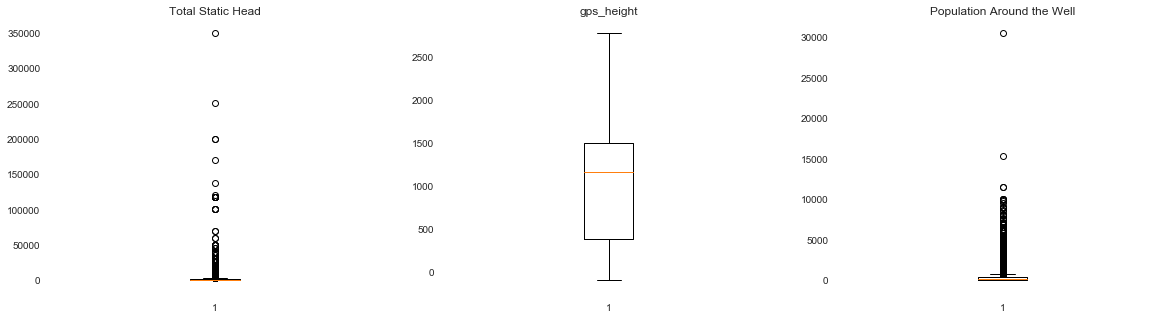

In [50]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
axs[0].boxplot(nonan_dataset1['amount_tsh'])
axs[0].set_title('Total Static Head')
axs[1].boxplot(nonan_dataset2['gps_height'])
axs[1].set_title('gps_height')
axs[2].boxplot(nonan_dataset3['population'])
axs[2].set_title('Population Around the Well')

In [51]:
sub_dataset=dataset[['amount_tsh','population']]
Q1 = sub_dataset.quantile(0.25)
Q3 = sub_dataset.quantile(0.75)
IQR = Q3 - Q1

((sub_dataset < (Q1 - 1.5 * IQR)) | (sub_dataset > (Q3 + 1.5 * IQR))).sum()

amount_tsh    2058
population    3105
dtype: int64

Eventhough according to the quantile calculation we find several outliers in **amount_tsh** and **population**, we don't have enough information regarding the static head amount and what would be regarded as the maximum amount thus we can not assume that these values are errors or outliers. 
Similarly, with population surrounding the well could go as high as 30000 so we don't have enough justification with the amount of missing values that we have to regard these as outliers or errors. 

With binning we can create categories for this values so that out model can train and predict on them in the cases that they do come up.

### 3.5. Imputing Missing Values  <a class="anchor" id="third2-bullet"></a>

##### <font color=#0078CC>KMode Clustering<font/>

A variation of k-means, **k-modes** method, will be used for clustering. This is because the dataset is primarily categorical variables and calculating distance between categorical variables is not applicable unless dummified, this alternative is chosen. 

Clusters will be created in this method, by first excluding the features that have missing values then merge the new cluster column back with the found clusters. Then for each missing value we will use the mode in its respective cluster for that feature to impute it. 

The kmodes minimizes the sum of feature values differences within-cluster. We will set the initializer at 'random' so that the initial centroids will be picked at random and run it 10 times with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of cost.

To choose the number of clusters in kmode there isn't a good method to decide the optimal number, so to decided to compare between creating 5, 6, and 7 clusters and compare the best iterations in eachone using the cost and the cluster feature values.

cost_(Clustering cost) is defined as the sum distance of all points totheir respective cluster centroids. In other words, distance within the cluster. We will aim to minimize this.

https://github.com/nicodv/kmodes/blob/master/kmodes/kprototypes.py#L365

In [52]:
#Removing features that have empty values

train_clust=dataset.dropna(axis='columns')
train_clust=train_clust[train_clust['data_set']=='train']  #using only trainset to find clusters
train_clust=train_clust.drop(colums_with_na_names,axis=1)  #exlude columns with na set
del train_clust['data_set']

# train_clust.drop(colums_with_na_names, axis=1, inplace=True)
train_clust.shape

(59400, 12)

In [53]:
train_clust.head()

,id,basin,region,lga,ward,extraction_type,extraction_type_group,extraction_type_class,source_type,waterpoint_type,status_group,year_recorded
0,69572,Lake Nyasa,Iringa,Ludewa,Mundindi,gravity,gravity,gravity,spring,communal standpipe,functional,2011
1,8776,Lake Victoria,Mara,Serengeti,Natta,gravity,gravity,gravity,rainwater harvesting,communal standpipe,functional,2013
2,34310,Pangani,Manyara,Simanjiro,Ngorika,gravity,gravity,gravity,dam,communal standpipe multiple,functional,2013
3,67743,Ruvuma / Southern Coast,Mtwara,Nanyumbu,Nanyumbu,submersible,submersible,submersible,borehole,communal standpipe multiple,non functional,2013
4,19728,Lake Victoria,Kagera,Karagwe,Nyakasimbi,gravity,gravity,gravity,rainwater harvesting,communal standpipe,functional,2011


In [54]:
import random
random.seed(9001)
# #5 clusters
# km1 = KModes(n_clusters=5, init='random', n_init=5, verbose=1)
# cluster1 = km1.fit_predict(train_clust[train_clust.columns[train_clust.columns!='id']])#exlude ID from variable to cluster based on
# #6 clusters
# km2 = KModes(n_clusters=6, init='random', n_init=5, verbose=1)
# clusters2 = km2.fit_predict(train_clust[train_clust.columns[train_clust.columns!='id']])
# #7 clusters
# km3 = KModes(n_clusters=7, init='random', n_init=5, verbose=1)
# cluster3 = km3.fit_predict(train_clust[train_clust.columns[train_clust.columns!='id']])
# #8 clusters
km4 = KModes(n_clusters=8, init='random', n_init=5, verbose=1)
cluster4 = km4.fit_predict(train_clust[train_clust.columns[train_clust.columns!='id']])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11964, cost: 276810.0
Run 1, iteration: 2/100, moves: 1522, cost: 276816.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4621, cost: 299336.0
Run 2, iteration: 2/100, moves: 994, cost: 298557.0
Run 2, iteration: 3/100, moves: 280, cost: 298507.0
Run 2, iteration: 4/100, moves: 26, cost: 298507.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 16488, cost: 276598.0
Run 3, iteration: 2/100, moves: 9761, cost: 274948.0
Run 3, iteration: 3/100, moves: 852, cost: 274452.0
Run 3, iteration: 4/100, moves: 507, cost: 274420.0
Run 3, iteration: 5/100, moves: 3, cost: 274420.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 15444, cost: 300653.0
Run 4, iteration: 2/100, moves: 84, cost: 300653.0

In [55]:
# # For 5 Clusters
# centroids1=pd.DataFrame(km1.cluster_centroids_)
# centroids1

In [56]:
# # For 6 Clusters
# centroids2=pd.DataFrame(km2.cluster_centroids_)
# centroids2

In [57]:
# # For 7 Clusters
# centroids3=pd.DataFrame(km3.cluster_centroids_)
# centroids3

In [58]:
# For 8 Clusters

centroids4=pd.DataFrame(km4.cluster_centroids_)
centroids4

,0,1,2,3,4,5,6,7,8,9,10
0,Lake Victoria,Mwanza,Bariadi,Nkungulu,nira/tanira,nira/tanira,handpump,shallow well,hand pump,functional,2011
1,Rufiji,Iringa,Njombe,Igosi,gravity,gravity,gravity,spring,communal standpipe,functional,2011
2,Wami / Ruvu,Pwani,Bagamoyo,Chalinze,submersible,submersible,submersible,borehole,communal standpipe,functional,2013
3,Lake Tanganyika,Shinyanga,Bukombe,Ilolangulu,nira/tanira,nira/tanira,handpump,shallow well,hand pump,functional,2012
4,Rufiji,Morogoro,Kilombero,Ifakara,swn 80,swn 80,handpump,shallow well,hand pump,functional,2011
5,Pangani,Kilimanjaro,Moshi Rural,Siha Kati,gravity,gravity,gravity,spring,communal standpipe,non functional,2013
6,Lake Victoria,Shinyanga,Kahama,Mishamo,other,other,other,shallow well,other,non functional,2013
7,Internal,Dodoma,Singida Rural,Soga,mono,mono,motorpump,borehole,communal standpipe multiple,non functional,2011


The best run with 8 clusters was the one with the least cost and more unique differentiation between features of the cluster centeroids.

* 5 clusters: cost=424611.0
* 6 clusters: cost=413897.0
* 7 clusters: cost=421526.0
* 8 clusters: cost=389722.0

<font color=#0078CC>The trainset above is used to determine which run and number of cluster is best. Then that cluster is fit to the whole dataset.<font/>

In [59]:
dataset_clust=dataset.dropna(axis='columns')  #using only trainset to find clusters
del dataset_clust['data_set']


dataset_clust.drop(colums_with_na_names, axis=1, inplace=True)   #exlude columns with na set
dataset_clust.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(74250, 12)

In [60]:
random.seed(9001)
cluster4 = km4.fit_predict(dataset_clust[ dataset_clust.columns[dataset_clust.columns!='id']])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 19473, cost: 358855.0
Run 1, iteration: 2/100, moves: 1020, cost: 358855.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 19814, cost: 381872.0
Run 2, iteration: 2/100, moves: 3380, cost: 381615.0
Run 2, iteration: 3/100, moves: 35, cost: 381615.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 14924, cost: 352574.0
Run 3, iteration: 2/100, moves: 1813, cost: 352520.0
Run 3, iteration: 3/100, moves: 265, cost: 352483.0
Run 3, iteration: 4/100, moves: 3, cost: 352483.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 30036, cost: 356553.0
Run 4, iteration: 2/100, moves: 6170, cost: 352091.0
Run 4, iteration: 3/100, moves: 1101, cost: 352091.0
Init: initializing centroids
Init: initializin

In [61]:
dataset_clust['cluster'] = pd.Series(cluster4, index=dataset_clust.index)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Add the cluster created above to original dataframe.

In [62]:
dataset = pd.merge(dataset,
                 dataset_clust[['id','cluster']],
                 on='id')
dataset.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,permit_na,construction_year_na,management_group_na,payment_na,water_quality_na,quantity_na,source_na,source_class_na,year_recorded,cluster
0,69572,6000.0,Roman,1390.0,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,0,0,0,0,0,0,0,0,2011,4
1,8776,NaN,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,0,0,0,0,0,0,0,0,2013,6
2,34310,25.0,Lottery Club,686.0,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,...,0,0,0,0,0,0,0,0,2013,6
3,67743,NaN,Unicef,263.0,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,0,0,0,0,0,0,0,0,2013,7
4,19728,NaN,Action In A,NaN,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,0,1,0,0,0,0,0,0,2011,4


##### <font color=#0078CC>Missing Value Imputation<font/>

Below the na each feature are filled with the mode of the cluster that it belongs to. 

In [63]:
f = lambda x: x.mode().iloc[0]
dataset= dataset.fillna(dataset.groupby('cluster').transform(f))

In [64]:
#check any na
pd.DataFrame(dataset.isna().sum()[dataset.isna().sum().ne(0)])

,0


## 4. Data Exploration <a class="anchor" id="forth-bullet"></a>

In [65]:
#Which are functional and which are not per funder and installer top 20

Plotting water pumps per class 

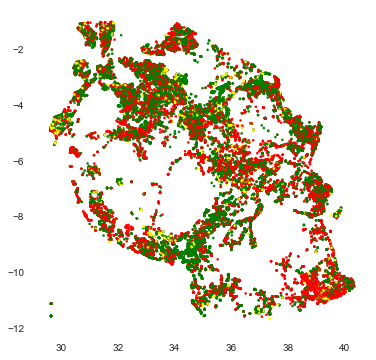

In [66]:
train = dataset[:59400]
colors = {'non functional':'red', 'functional needs repair':'yellow', 'functional':'green', '*unknown*':'black'}

plt.figure(figsize=(6, 6))
plt.scatter(x = train['longitude'],
            y = train['latitude'],
            c = train['status_group'].apply(lambda x: colors[x]),
            s = 5)
plt.show()

### 4.1. More Data Cleaning and Transformations <a class="anchor" id="forth1-bullet"></a>

We need to make a few amendemnts and test how our model performs. Two main transformations are made below, 
- the numeric colums are scaled with minmax scaler
- Bin amount_tsh and population
- replace columns with scaled and bins to avoid model training on extreme values

We will check with choose which ones to use for final model after feature selection. 

**<font color=#0078CC>Binning<font/>**

0      3643
1      1484
2      8787
3      4046
4     50358
5      2767
6      1717
7      1140
8       235
9        30
10       43
Name: bin_amount_tsh, dtype: int64


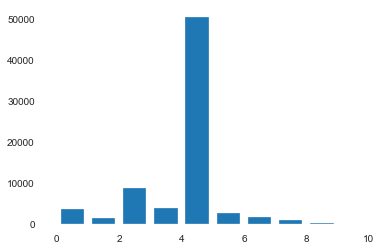

In [67]:
bat_bins = [0,20, 45, 50, 300, 500, 1500, 3000, 8000, 20000, 30000, np.inf]
bat_labels = list(range(len(bat_bins) - 1))

dataset['bin_amount_tsh'] = pd.cut(dataset['amount_tsh'],
                                  bins = bat_bins, 
                                  labels = bat_labels)
#Rename the Bins

plt.hist(dataset["bin_amount_tsh"], bins = bat_labels, rwidth = 0.75)
print(dataset["bin_amount_tsh"].value_counts().sort_index())

0    35616
1    11103
2    12316
3     9413
4     4003
5     1799
Name: bin_population, dtype: int64


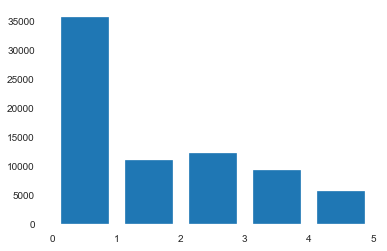

In [68]:
bp_bins = [0, 1, 100, 250, 500, 1000, np.inf]
bp_labels = list(range(len(bp_bins) - 1))

#Rename the Bins

dataset['bin_population'] = pd.cut(dataset['population'],
                                  bins = bp_bins, 
                                  labels = bp_labels)

plt.hist(dataset["bin_population"], bins = bp_labels, rwidth = 0.75)
print(dataset["bin_population"].value_counts().sort_index())

**<font color=#0078CC>Scaling<font/>**

In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols=['latitude','longitude','gps_height','population','amount_tsh']

df_scaled = pd.DataFrame(scaler.fit_transform(dataset[cols]), columns=cols)

dataset['latitude']=df_scaled['latitude']
dataset['longitude']=df_scaled['longitude']
dataset['gps_height']=df_scaled['gps_height']
dataset['population']=df_scaled['population']
dataset['amount_tsh']=df_scaled['amount_tsh']

In [70]:
rm_cols=['funder','installer', 'lga','ward','subvillage','cluster','id'] #we will also no longer use 'cluster'
dataset.drop(rm_cols, axis=1, inplace=True)

In [71]:
# dataset['construction_year']=dataset['construction_year'].astype('int')
# dataset['amount_tsh']=dataset['amount_tsh'].astype('int')
# dataset['longitude']=dataset['longitude'].astype('int')
# dataset['latitude']=dataset['latitude'].astype('int')
# dataset['year_recorded']=dataset['year_recorded'].astype('int')

#Changing datatypes from Objects to Categories.
for col in dataset:
    if dataset.dtypes[col].name == 'object':
        dataset[col] = dataset[col].astype('category')

### Dummify and Split Train Test 

In [72]:
#We will convert all categoricals to dummy
#We will explude the column that define NA and the target column.

rm_tar_na=colums_with_na_names+['status_group','data_set']

dummified_dataset = pd.get_dummies(dataset.drop(rm_tar_na, axis=1)).reset_index(drop=True)
tar_na_cols=pd.DataFrame(dataset[rm_tar_na].reset_index(drop=True))

dummified_dataset.shape, tar_na_cols.shape

((74250, 159), (74250, 20))

In [73]:
dummified_dataset=pd.concat([dummified_dataset,tar_na_cols],axis=1)
dummified_dataset.shape

(74250, 179)

<div class="alert alert-block alert-success">
The train and test will be separated before the next steps as the data cleaning is compeleted. It will be split using the annotation added under column **data_set** and that column will be removed as it no longer will be used. 

In [74]:
trainset=dummified_dataset[dummified_dataset['data_set']=='train']
testset=dummified_dataset[dummified_dataset['data_set']=='test']
del testset['data_set']
del trainset['data_set']
trainset.shape,testset.shape

((59400, 178), (14850, 178))

## 5. Dataset Balance <a class="anchor" id="fifth-bullet"></a>

As established [here](#imbalance-bullet), there is a class imbalance 
occurring in datasets with a disproportionate ratio of observations in each class. This will make our model biased as it learns more on the more frequently occuring classes. 
To handle this disproportionality we will test the two options of up-sampling our minority class and down-sampling our majority class. To choose which one is better the inital approach was to fit the prediction to a Logistic Regression and compare the performance of each method, however the number of observations in the minority class are too 

In [75]:
status_group

,status_group,%
functional,32259,54.308081
non functional,22824,38.424242
functional needs repair,4317,7.267677


### 5.1. Up-Sample Minority Class

We only have 7% of the total observation that is for the third category which is "functional needs repair". We will balance this to the 'functional' class and see how the accuracy performs. 

In [76]:
df_majority1 = trainset[trainset['status_group']=='functional']
df_majority2 = trainset[trainset['status_group']=='non functional']
df_minority = trainset[trainset['status_group']=='functional needs repair']

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=32259, #upsamples to the largest class
                                 random_state=123)

upsampled_dataset=pd.concat([df_majority1,df_majority2,df_minority_upsampled])

status_group_upsampled=pd.DataFrame(upsampled_dataset["status_group"].value_counts())
status_group_upsampled['%']=(upsampled_dataset["status_group"].value_counts())/len(upsampled_dataset)*100
status_group_upsampled

,status_group,%
functional needs repair,32259,36.934121
functional,32259,36.934121
non functional,22824,26.131758
*unknown*,0,0.000000


In [77]:
trainset_b=upsampled_dataset  ##We update the here with upsampled
trainset_b.shape  #balanced

(87342, 178)

Logistic regression can not be done on categorical variables, we need to simply convert all variables to dummy variable.

### Random Forest Before and After Up-Sampeling

We will first split the both balanced (trainset_b) and unbalanced (trainset_b) trainsets into train and test (or validation) and see how random forest perfoms in each case interms of accuracy, and the unique classes it predicts.

#### Before Up-Sampeling

In [78]:
from sklearn.model_selection import train_test_split

def split_df(df, seed=None, percentage=0.8):
    
    X = df.loc[:, df.columns != 'status_group']
    y = df['status_group']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed)

X_train, X_test, y_train, y_test = split_df(trainset, seed=42, percentage=0.8) #the trainset here is not balanced

from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
ranfor_ini=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
ranfor_ini.fit(X_train,y_train)

y_pred=ranfor_ini.predict(X_test)

print( accuracy_score(y_pred, y_test)), print(np.unique(y_pred))  #check which classes our model is predicting

0.8273569023569024
['functional' 'functional needs repair' 'non functional']


(None, None)

In [82]:
from sklearn import tree

tree_initial = tree.DecisionTreeClassifier()
tree_initial.fit(X=X_train, y=y_train)
tree_initial.feature_importances_ 
tree_initial.score(X=X_test, y=y_test)

0.7867003367003367

#### After Up-Sampeling

In [83]:
from sklearn.model_selection import train_test_split

def split_df(df, seed=None, percentage=0.8):
    
    X = df.loc[:, df.columns != 'status_group']
    y = df['status_group']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed)

X_train, X_test, y_train, y_test = split_df(trainset_b, seed=42, percentage=0.8) #the trainset here is not balanced

from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
ranfor_baseline=RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
ranfor_baseline.fit(X_train,y_train)

y_pred=ranfor_baseline.predict(X_test)

print( accuracy_score(y_pred, y_test)), print(np.unique(y_pred))  #check which classes our model is predicting

0.8997080542675597
['functional' 'functional needs repair' 'non functional']


(None, None)

In [84]:
from sklearn import tree
tree_baseline = tree.DecisionTreeClassifier()
tree_baseline.fit(X=X_train, y=y_train)
tree_baseline.feature_importances_ 
tree_baseline.score(X=X_test, y=y_test)

0.8776117694201157

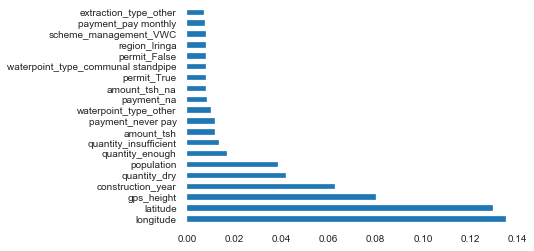

In [85]:
feat_importances_rf = pd.Series(ranfor_baseline.feature_importances_, index=trainset_b.drop(['status_group'],axis=1).columns)
feat_importances_rf.nlargest(20).plot(kind='barh')

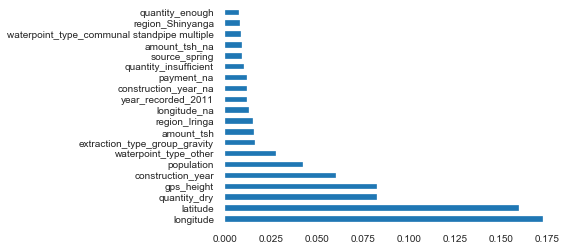

In [95]:
feat_importances_tree = pd.Series(tree_baseline.feature_importances_, index=trainset_b.drop(['status_group'],axis=1).columns)
feat_importances_tree.nlargest(20).plot(kind='barh')

Eventhough the minority class was only 7% of the total observation, the model without balancing was able to predict with for that class. This might be an indication that there are features distinctly indefying which water pumps need repair. However, upsampling does improve the overall accuracy of the prediction significantly. 
The improvement in accuracy is seen in both decision tree and random forest.

<div class="alert alert-block alert-success">
We will use this model as these models as baseline and compare how it improves with accuracy and important features once feature engineering and cross validation is applied.

## 6. Feature Selection <a class="anchor" id="sixth-bullet"></a>

### 6.1. Train and Validation Split <a class="anchor" id="sixth1-bullet"></a>

In [89]:
#This is similiar as baseline with the balanced trainset
from sklearn.model_selection import train_test_split

def split_df(df, seed=None, percentage=0.8):
    
    X = df.loc[:, df.columns != 'status_group']
    y = df['status_group']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed)

X_train, X_test, y_train, y_test = split_df(trainset_b, seed=42, percentage=0.8)

In [ ]:
# #K-Fold Cross Validation
# X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]]) # create an 2d array i.e independent variables matrix
# Y = np.array([1, 2, 3, 4]) # Create another array i.e dependent vector

# kf = KFold(n_splits=10) # 10 folds 
# kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

# print(kf) 
# KFold(n_splits=10, random_state=None, shuffle=False)

### 6.2. Chi-squared Selection

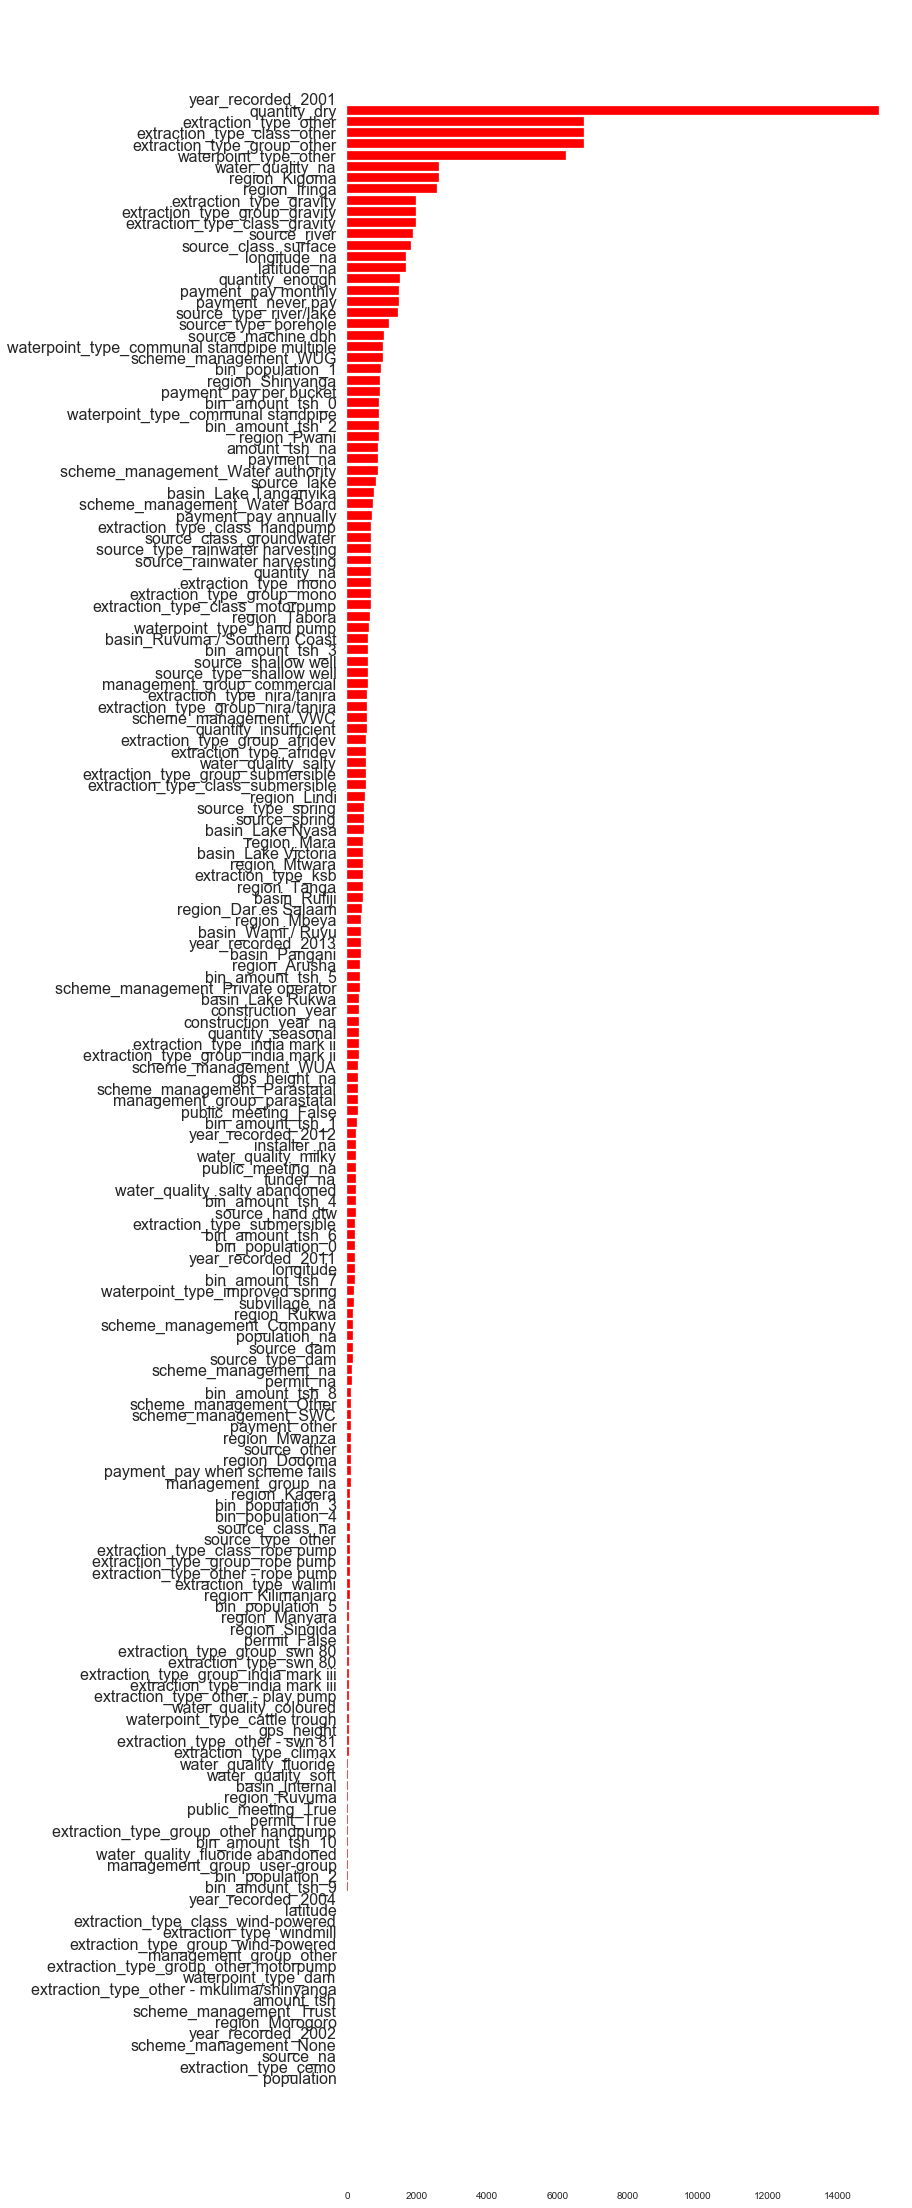

In [97]:

X = trainset_b.loc[:, trainset_b.columns != 'status_group']
y = trainset_b['status_group']

from sklearn.feature_selection import SelectKBest, chi2
chi2_selector = SelectKBest(score_func=chi2).fit(X,y)


# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = []
for i in range(len(X.columns)):
    chi2_features.append(X.columns[indices[i]])
# Now plot
plt.figure(figsize=(10,40))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(chi2_features, chi2_selector.scores_[indices[range(len(X.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

In [103]:
for i in range(1,len(chi2_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,tree.DecisionTreeClassifier(n_iter = 1000, penalty='none').fit(X_train[chi2_features[:i]], y_train).predict(X_test[chi2_features[:i]]))))
    print()

Features used to train the model = 1


TypeError: __init__() got an unexpected keyword argument 'n_iter'

In [99]:
chi2_features[:20] #The top 20 important features according the finding in Chi-square

['year_recorded_2001',
 'quantity_dry',
 'extraction_type_other',
 'extraction_type_class_other',
 'extraction_type_group_other',
 'waterpoint_type_other',
 'water_quality_na',
 'region_Kigoma',
 'region_Iringa',
 'extraction_type_gravity',
 'extraction_type_group_gravity',
 'extraction_type_class_gravity',
 'source_river',
 'source_class_surface',
 'longitude_na',
 'latitude_na',
 'quantity_enough',
 'payment_pay monthly',
 'payment_never pay',
 'source_type_river/lake']

In [ ]:
chi2_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
chi2_initial_lm_mod.fit(X_train[chi2_features[:6]], y_train)

In [ ]:
get_feature_importance(chi2_initial_lm_mod)

In [ ]:
#SVM
from sklearn import svm

C = 1

svm_initial = svm.SVC(C,kernel=)
svm_initial.fit(X_train, y_train)

In [ ]:
def plot_svm_decision(X_train, y_train, clf):

    plt.figure(figsize=(15,15))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:,0], cmap=plt.cm.RdBu)
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.show()
    
    
plot_svm_decision(X_train, y_train, clf)

In [ ]:
>>> from sklearn.datasets import load_iris
>>> from sklearn.model_selection import cross_val_score
>>> from sklearn.tree import DecisionTreeClassifier
>>> clf = DecisionTreeClassifier(random_state=0)
>>> iris = load_iris()
>>> cross_val_score(clf, iris.data, iris.target, cv=10)
...                             # doctest: +SKIP
...
array([ 1.     ,  0.93...,  0.86...,  0.93...,  0.93...,
        0.93...,  0.93...,  1.     ,  0.93...,  1.      ])

In [103]:
#Decision Tree
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X=X_train, y=y_train)
clf.feature_importances_ 
clf.score(X=X_test, y=y_test) # 1.0

0.8147970048773786

In [270]:
feat=trainset_b[trainset_b != 'status_group']
 
# Validation Set approach : take 80% of the data as the training set and 20 % as the test set. X is a dataframe with  the input variable
X = trainset_b.loc[:, trainset_b.columns != 'status_group']
 
# Y is the target or output variable 
y = trainset_b['status_group']
 
length_to_split = int(len(feat) * 0.8)
# Splitting the X and y into train and test datasets
X_train, X_test = X[:length_to_split], X[length_to_split:]
y_train, y_test = y[:length_to_split], y[length_to_split:]
 
# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
    
clf = tree.DecisionTreeClassifier(random_state=20)
 
# Create the model on train dataset
model = clf.fit(X_train, y_train)
 
# Calculate the accuracy
print(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)
 
# KFold Cross Validation approach
kf = KFold(n_splits=10,shuffle=False)
kf.split(X)    
     
# Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
accuracy_model = []
 
# # Iterate over each train-test split
for train_index, test_index in kf.split(X):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Train the model
    model = clf.fit(X_train, y_train)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)
 
# # Print the accuracy    
pd.DataFrame(accuracy_model)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


(69873, 172) (17469, 172)
(69873,) (17469,)
88.96903085465682


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: Input contains NaN

In [ ]:
scores = pd.DataFrame(accuracy_model,columns=['Scores'])
scores